In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm-dataset/dataset_sarcasm.csv
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__results__.html
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__resultx__.html
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__notebook__.ipynb
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__output__.json
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/custom.css
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__results___files/__results___41_1.png
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__results___files/__results___31_0.png
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__results___files/__results___66_0.png
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__results___files/__results___29_1.png
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__results___files/__results___19_1.png
/kaggle/input/nlp-using-glove-embeddings-99-87-accuracy/__results___files/__results___36_2.png
/kaggle/input/nlp-us

In [5]:
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, Dropout, SpatialDropout1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Load dataset
df = pd.read_csv('/kaggle/input/sarcasm-dataset/dataset_sarcasm.csv') 
# Text Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['clean_text'] = df['headline'].apply(clean_text)
labels = np.array(df['is_sarcastic'])  
# Tokenization & Padding
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100    

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Convert labels to numpy array
labels = np.array(df['is_sarcastic'])

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [6]:
# Load GloVe embeddings
embedding_index = {}
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create the embedding matrix
word_index = tokenizer.word_index  # assuming you already fitted your tokenizer
vocab_size = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        break
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [14]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    SpatialDropout1D(0.2),

    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalMaxPooling1D(),  # Reduce the 3D tensor to 2D

    # Add a Reshape layer to explicitly define input shape
    tf.keras.layers.Reshape((1, 64)),  # Reshape to (batch_size, 1, 64) for LSTM

    LSTM(32, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),

    Dense(1, activation='sigmoid')
])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


# Compile Model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5663 - loss: 1.6711 - val_accuracy: 0.8073 - val_loss: 0.7654 - learning_rate: 0.0010
Epoch 2/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8508 - loss: 0.6291 - val_accuracy: 0.8330 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 3/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9218 - loss: 0.3271 - val_accuracy: 0.8374 - val_loss: 0.4548 - learning_rate: 0.0010
Epoch 4/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9530 - loss: 0.2090 - val_accuracy: 0.8356 - val_loss: 0.5249 - learning_rate: 0.0010
Epoch 5/20
711/716 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9611 - loss: 0.1754
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9610 - loss: 0.1755 - val_accuracy: 0.8298 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 6/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9734 - loss: 0.1

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


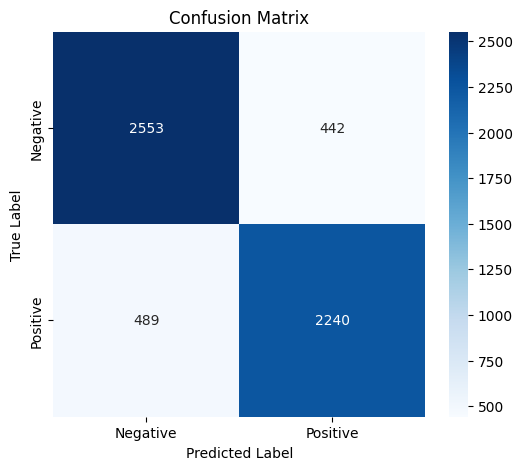

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2995
           1       0.84      0.82      0.83      2729

    accuracy                           0.84      5724
   macro avg       0.84      0.84      0.84      5724
weighted avg       0.84      0.84      0.84      5724



In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print(classification_report(y_test, y_pred_labels))


In [16]:
# Save Model
model.save('sarcasm_cnn_lstm.h5')

# Load and Test Model
loaded_model = tf.keras.models.load_model('sarcasm_cnn_lstm.h5')
predictions = (loaded_model.predict(X_test) > 0.5).astype("int32")

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
import pickle

# Tokenizer ko save karo
with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
